In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split, GridSearchCV
from load_data import load_categorical_data
from load_data import load_categorical_more_data
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import r2_score
from scipy.stats import ttest_ind as ttest
from sklearn.metrics import mean_squared_error
import time

In [119]:
import openpyxl 
import os

In [2]:
def MinMaxNormal(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true=np.array(y_true)
    y_pred=np.array(y_pred)
    MSPE = (sum((MinMaxNormal(y_true)-MinMaxNormal(y_pred))**2)/(y_pred.size))/(MinMaxNormal(y_true).mean())
    MSPE = MSPE*100
    return np.abs(MSPE)

In [4]:
"""
Use Decision Tree to fit the relationship between 
homeless_real_value and other variables, except 
no_longer_homeless, prevention_duty, and relief duty.
"""

#Read data
categorical_data,local_authority_names,total_duty_owed,total_population_in_households,prevention_duty_owed,relief_duty_owed,support_need_homeless,no_longer_homeless,homeless_real_value,categorical_waiting_list_size,social_housing_lettings_2021,band_A_B_properties,band_C_D_properties,band_E_F_properties,band_G_H_properties,median_prices,median_earning_gross,categorical_median_afforability_ratio,lower_quatile_prices,lower_quatile_earning_gross,categorical_lower_quatile_afforability_ratio = load_categorical_data()

affordableRent_start,social_housing_start,intermediate_start,total_affordable_start,affordable_complete,social_complete,intermediate_complete,total_affordable_complete=load_categorical_more_data()

In [5]:
# features include duty owed
X = pd.DataFrame([total_duty_owed,\
                  total_population_in_households,\
                  support_need_homeless,\
                  categorical_waiting_list_size,\
                  social_housing_lettings_2021,band_A_B_properties,\
                  band_C_D_properties,band_E_F_properties,band_G_H_properties,\
                  median_prices,median_earning_gross,categorical_median_afforability_ratio,\
                  lower_quatile_prices,lower_quatile_earning_gross,\
                  categorical_lower_quatile_afforability_ratio,\
                  affordableRent_start,social_housing_start,\
                  intermediate_start,total_affordable_start,\
                  affordable_complete,social_complete,intermediate_complete,\
                  total_affordable_complete])

In [6]:
# features without duty owed
X = pd.DataFrame([total_population_in_households,\
                  support_need_homeless,\
                  categorical_waiting_list_size,\
                  social_housing_lettings_2021,band_A_B_properties,\
                  band_C_D_properties,band_E_F_properties,band_G_H_properties,\
                  median_prices,median_earning_gross,categorical_median_afforability_ratio,\
                  lower_quatile_prices,lower_quatile_earning_gross,\
                  categorical_lower_quatile_afforability_ratio,\
                  affordableRent_start,social_housing_start,\
                  intermediate_start,total_affordable_start,\
                  affordable_complete,social_complete,intermediate_complete,\
                  total_affordable_complete])

In [98]:
data_table = categorical_data.drop(labels='Local',axis = 1)
data_table = data_table.drop(labels='Local Authority code',axis = 1)
data_table = data_table.drop(labels='Local Authority name',axis = 1)
data_table = data_table.drop(labels='Homeless (including intentionally homeless)',axis = 1)
data_table = data_table.drop(labels='Threatened with homelessness within 56 days - Prevention duty owed',axis = 1)
data_table = data_table.drop(labels='Homeless - Relief duty owed4',axis = 1)
data_table = data_table.drop(labels='Intermediate Rent (Starts on Site)',axis = 1)
data_table = data_table.drop(labels='Intermediate Rent (Completions)',axis = 1)
data_table = data_table.drop(labels='Affordable Home Ownership (Starts on Site)',axis = 1)
data_table = data_table.drop(labels='Affordable Home Ownership (Completions)',axis = 1)
data_table = data_table.drop(labels='Market (Starts on Site)',axis = 1)
data_table = data_table.drop(labels='Market  (Completions)',axis = 1)
data_table = data_table.drop(labels='C_D_property_counts',axis = 1)
data_table = data_table.drop(labels='E_F_property_counts',axis = 1)
data_table = data_table.drop(labels='G_H_property_counts',axis = 1)
data_table = data_table.drop(labels='median_houses_2020',axis = 1)
data_table = data_table.drop(labels='median_earning_2020',axis = 1)
data_table = data_table.drop(labels='ratio_by_medians_2020',axis = 1)
data_table = data_table.drop(labels='Total Affordable (Starts on Site)',axis = 1)
data_table = data_table.drop(labels='Total Affordable (Completions)',axis = 1)
data_table = data_table.drop(labels='Total (Starts on Site)',axis = 1)
data_table = data_table.drop(labels='Total (Completions)',axis = 1)
data_table = data_table.drop(labels='lower_quatile_houses_2020',axis = 1)
data_table = data_table.drop(labels='lower_quatile_earning_2020',axis = 1)

In [99]:
data_table.columns

Index(['Total owed a prevention or relief duty',
       'Number of households in area4 (000s)',
       'Total households with support needs', 'Total secured accommodation',
       'Size_of_social_housing_waiting_list_2021', '2021 Total Lettings',
       'Affordable Rent (Starts on Site)', 'Social Rent (Starts on Site)',
       'Affordable Rent (Completions)', 'Social Rent (Completions)',
       'A_B_property_counts', 'ratio_by_lower_quatile_2020'],
      dtype='object')

In [100]:
feature_space = data_table.iloc[:, data_table.columns != 'Total owed a prevention or relief duty'].astype('float')
feature_class = data_table.iloc[:, data_table.columns == 'Total owed a prevention or relief duty'].astype('int')

In [101]:
training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20, 
                                                                    random_state = 0)

# Cleaning test sets to avoid future warning messages
normal_class_set = class_set
class_set = normal_class_set.values.ravel() 
normal_test_class_set = test_class_set
test_class_set = normal_test_class_set.values.ravel() 

In [102]:
# Set the random state for reproducibility
fit_rf = RandomForestClassifier(random_state=0)

In [109]:
np.random.seed(0)
start = time.time()

param_dist = {'n_estimators':[400,500,600],'max_depth': [2,3,5,10],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 3,
                     param_grid=param_dist, 
                     n_jobs = 5)

cv_rf.fit(training_set, class_set)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 400}
Time taken in grid search:  173.94


In [110]:
# Set best parameters given by grid search 
fit_rf = fit_rf.set_params(n_estimators = 400,criterion = 'entropy',
                  max_features = 'auto', 
                  max_depth = 5)

In [111]:
hundredYard_forest = fit_rf.fit(training_set, class_set)

In [112]:
predictions = hundredYard_forest.predict(test_set)

In [113]:
feature_importance_score = list(hundredYard_forest.feature_importances_)

In [114]:
print('SL Model R2 Score: '+str(r2_score(test_class_set,predictions)))

coef = np.corrcoef(test_class_set,predictions)
coef = coef[0,1]
print('SL Model Correlation Coefficient: '+str(coef))

SLMSPE = mean_absolute_percentage_error(test_class_set,predictions)
print('SL Mean Squared Percentage Error: '+str(SLMSPE))

SL Model R2 Score: 0.6700553285721087
SL Model Correlation Coefficient: 0.8208157517207498
SL Mean Squared Percentage Error: 16.7525858044938


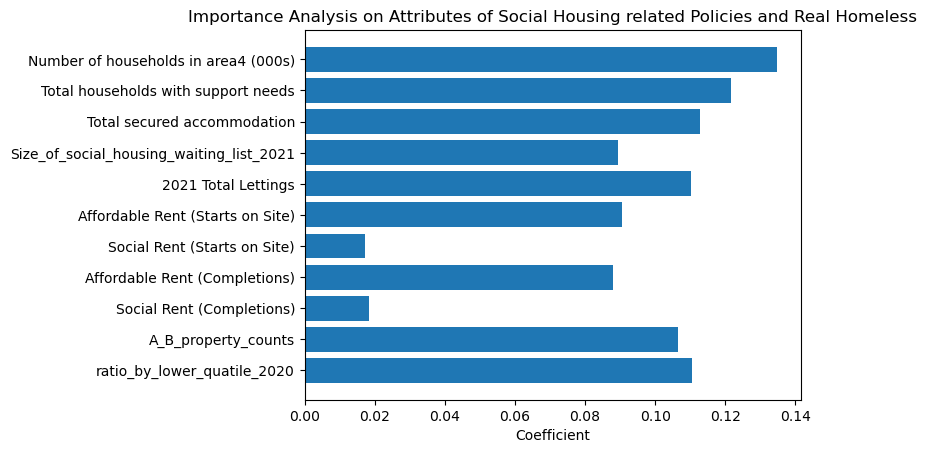

In [115]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
x_names = list(hundredYard_forest.feature_names_in_[:])
y_pos = np.arange(len(x_names))

ax.barh(y_pos, feature_importance_score, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticks(y_pos)
ax.set_yticklabels(list(x_names))
ax.set_xlabel('Coefficient')
ax.set_title('Importance Analysis on Attributes of Social Housing related Policies and Real Homeless')
plt.savefig('Figure/random_forest_importance_score_analysis.png')
plt.show()

In [120]:
feature_importance = pd.DataFrame(feature_importance_score)
feature_importance.columns = ['RF Importance']
feature_importance.index = list(hundredYard_forest.feature_names_in_[:])
cwd = os.getcwd()
feature_importance.to_csv(os.path.join(cwd, "ResultTables/example_randome_forest_model_scores.csv"))  

NameError: name 'example_mlr_scores' is not defined

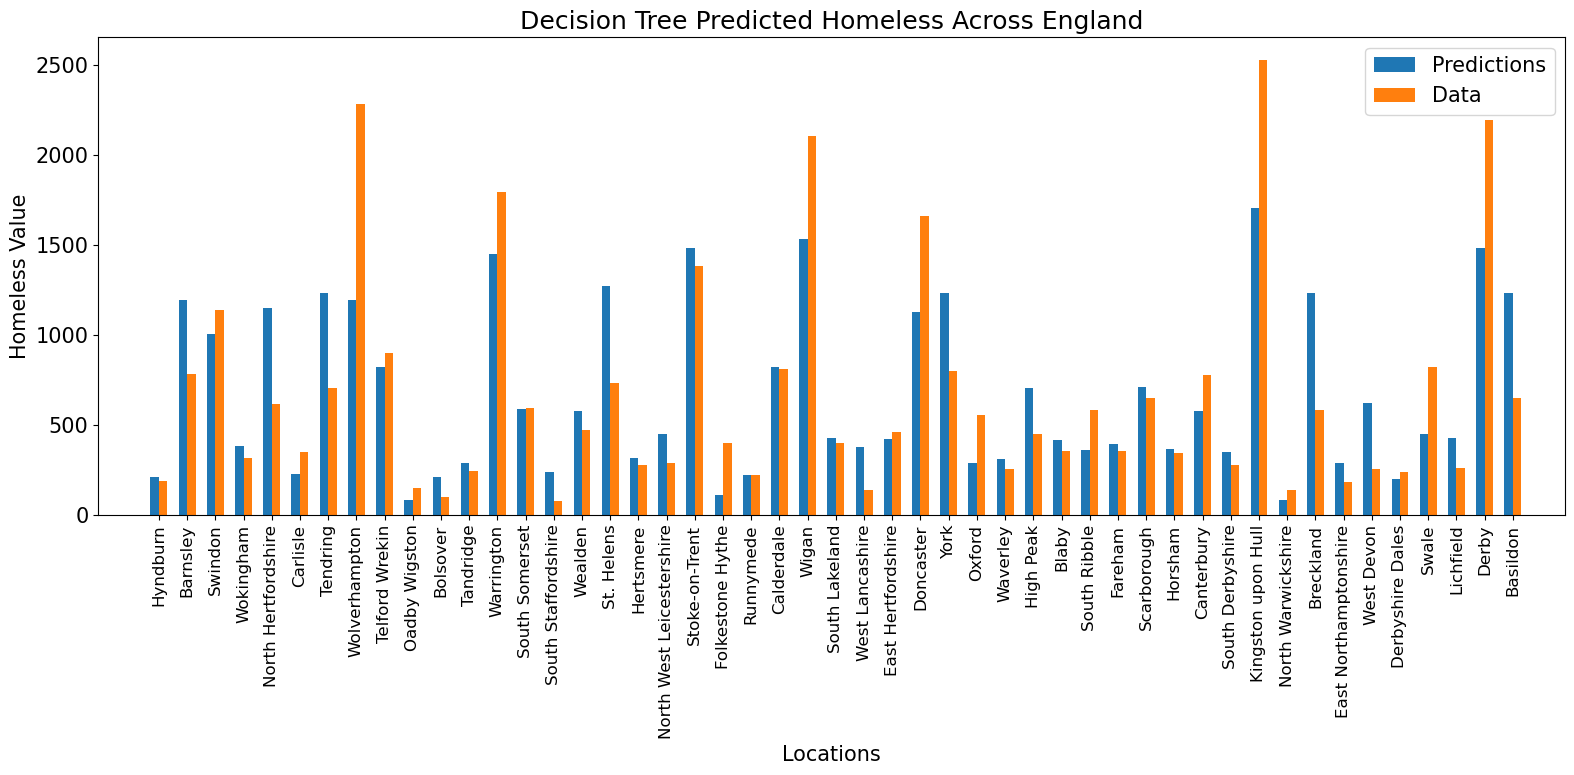

In [116]:
#Plot and save the test results
f_predictions = predictions
test_y = test_class_set

N =len(f_predictions)
locations = range(1,N+1)

# Position of bars on x-axis
y_pos = np.arange(N)

# Width of a bar 
width = 0.3

# Plotting
plt.rcParams.update({'font.size': 15})
fig_r2, ax = plt.subplots(figsize=(16,8))
plt.bar(y_pos, f_predictions, width, label='Predictions')
plt.bar(y_pos + width, test_y, width, label='Data')
plt.xlabel('Locations')
plt.ylabel('Homeless Value')
plt.title('Decision Tree Predicted Homeless Across England')

# xticks()
plt.xticks(y_pos + width / 2, list(local_authority_names[normal_test_class_set.index]))
plt.setp(ax.get_xticklabels(), fontsize=12, rotation='vertical')

# Size of the Plot
plt.xlim([-2,max(y_pos)+2])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('Figure/Random_forest_test_result.png')
plt.show()